In [1]:
"""

GPM Matching from Kai M.

"""

'\n\nGPM Matching from Kai M.\n\n'

In [54]:
import warnings
warnings.filterwarnings('ignore')
import wradlib as wrl
import matplotlib.pyplot as pl
import matplotlib as mpl
from matplotlib.collections import PatchCollection
from matplotlib.colors import from_levels_and_colors
from matplotlib.path import Path
import matplotlib.patches as patches
import matplotlib.cm as cm
try:
    get_ipython().magic("matplotlib inline")
except:
    pl.ion()
import numpy as np
import datetime as dt
from osgeo import osr
import glob

In [4]:
# define GPM data set
#gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141007-S015721-E032951.003445.V05A.HDF5'
gpm_file_path = '/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008-S084747-E102017.003465.V05A.HDF5'

gpm_file = wrl.util.get_wradlib_data_file(gpm_file_path)

# define matching ground radar file
#gr_file_path = '/automount/radar-archiv/scans/2014/2014-10/2014-10-07/ppi_1p5deg/2014-10-07--02:37:44,00.mvol'
#gr_file_path = '/automount/radar-archiv/scans/2014/2014-10/2014-10-08/n_ppi_010deg/2014-10-08--09:45:00,00.mvol'

#gr_file_path = '/automount/ags/velibor/data/dwd_dual_pol/20140729_ess/polara_10410_Volume10_20140729_2246_ShortRange_0035_Zh.hd5'

gr_file_path = '/automount/radar/dwd/dx/2014/2014-10/2014-10-08/raa00-dx_10410-1410080945-ess---bin'


gr2gpm_file = wrl.util.get_wradlib_data_file(gr_file_path)
#gr2gpm_file = wrl.util.get_wradlib_data_file('/user/velibor/SHKGPM/Australien-gpm/volmatch/GPM_example/IDR66_20141206_094829.vol.h5')

# define TRMM data sets
#trmm_2a23_file = wrl.util.get_wradlib_data_file('/user/velibor/SHKGPM/Australien-gpm/volmatch/TRMM_example/2A-RW-BRS.TRMM.PR.2A23.20100206-S111422-E111519.069662.7.HDF')
#trmm_2a25_file = wrl.util.get_wradlib_data_file('/user/velibor/SHKGPM/Australien-gpm/volmatch/TRMM_example/2A-RW-BRS.TRMM.PR.2A25.20100206-S111422-E111519.069662.7.HDF')

# define matching ground radar file
#gr2trmm_file = wrl.util.get_wradlib_data_file('/user/velibor/SHKGPM/Australien-gpm/volmatch/TRMM_example/IDR66_20100206_111233.vol.h5')

In [5]:
print (gr2gpm_file)
print (gpm_file)

/automount/radar/dwd/dx/2014/2014-10/2014-10-08/raa00-dx_10410-1410080945-ess---bin
/automount/ags/velibor/gpmdata/dprV7/2A.GPM.DPR.V7-20170308.20141008-S084747-E102017.003465.V05A.HDF5


In [6]:
# Space-born precipitation radar parameters
sr_pars = {"gpm": {
    "zt": 407000.,  # orbital height of GPM                 APPROXIMATION!
    "dr": 125.,      # gate spacing of GPM
    "gr_file": gr2gpm_file,
}}

In [7]:
# Set parameters for this procedure
bw_sr = 0.71                  # SR beam width
platf = "gpm"                 # SR platform/product: one out of ["gpm", "trmm"]
zt = sr_pars[platf]["zt"]     # SR orbit height (meters)
dr_sr = sr_pars[platf]["dr"]  # SR gate length (meters)
gr_file = sr_pars[platf]["gr_file"]


ee = 2     ###########?

In [8]:
sr_pars['gpm']['gr_file']#['zt', 'dr', 'gr_file']

/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/home/velibor/anaconda2/envs/wradlib/lib/python2.7/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


'/automount/radar/dwd/dx/2014/2014-10/2014-10-08/raa00-dx_10410-1410080945-ess---bin'

In [9]:
def _get_tilts(dic):
    i = 0
    for k in dic.keys():
        if 'dataset' in k:
            i += 1
    return i



def read_gr(filename, loaddata=True):

    gr_data = wrl.io.read_generic_netcdf(filename)
    dat = gr_data['what']['date']
    tim = gr_data['what']['time']
    date = dt.datetime.strptime(dat + tim, "%Y%d%m%H%M%S")
    source = gr_data['what']['source']

    lon = gr_data['where']['lon']
    lat = gr_data['where']['lat']
    alt = gr_data['where']['height']

    if gr_data['what']['object'] == 'PVOL':
        ntilt = _get_tilts(gr_data)
    else:
        raise ValueError('GR file is no PPI/Volume File')

    ngate = np.zeros(ntilt, dtype=np.int16)
    nbeam = np.zeros(ntilt)
    elang = np.zeros(ntilt)
    r0 = np.zeros(ntilt)
    dr = np.zeros(ntilt)
    a0 = np.zeros(ntilt)

    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]
        a0[i] = dset['how']['astart']
        elang[i] = dset['where']['elangle']
        ngate[i] = dset['where']['nbins']
        r0[i] = dset['where']['rstart']
        dr[i] = dset['where']['rscale']
        nbeam[i] = dset['where']['nrays']

    if ((len(np.unique(r0)) != 1) |
            (len(np.unique(dr)) != 1) |
            (len(np.unique(a0)) != 1) |
            (len(np.unique(nbeam)) != 1) |
            (nbeam[0] != 360)):
        raise ValueError('GroundRadar Data layout dos not match')

    gr_dict = {}
    gr_dict.update({'source': source, 'date': date, 'lon': lon, 'lat': lat,
                    'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                    'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
    if not loaddata:
        return gr_dict

    sdate = []
    refl = []
    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]
        dat = dset['what']['startdate']
        tim = dset['what']['starttime']
        date = dt.datetime.strptime(dat + tim, "%Y%d%m%H%M%S")
        sdate.append(date)
        data = dset['data1']
        quantity = data['what']['quantity']
        factor = data['what']['gain']
        offset = data['what']['offset']
        if quantity == 'DBZH':
            dat = data['variables']['data']['data'] * factor + offset
            refl.append(dat)

    sdate = np.array(sdate)
    refl = np.array(refl)

    gr_dict.update({'sdate': sdate, 'refl': refl})

    return gr_dict

def read_gpm(filename, bbox):
    pr_data = Dataset(filename, mode="r")
    lon = pr_data['NS'].variables['Longitude']
    lat = pr_data['NS'].variables['Latitude']

    poly = [[bbox['left'], bbox['bottom']],
            [bbox['left'], bbox['top']],
            [bbox['right'], bbox['top']],
            [bbox['right'], bbox['bottom']],
            [bbox['left'], bbox['bottom']]]
    mask = get_clip_mask(np.dstack((lon[:], lat[:])), poly)
    mask = np.nonzero(np.count_nonzero(mask, axis=1))
    lon = lon[mask]
    lat = lat[mask]

    year = pr_data['NS']['ScanTime'].variables['Year'][mask]
    month = pr_data['NS']['ScanTime'].variables['Month'][mask]
    dayofmonth = pr_data['NS']['ScanTime'].variables['DayOfMonth'][mask]
    # dayofyear = pr_data['NS']['ScanTime'].variables['DayOfYear'][mask]
    hour = pr_data['NS']['ScanTime'].variables['Hour'][mask]
    minute = pr_data['NS']['ScanTime'].variables['Minute'][mask]
    second = pr_data['NS']['ScanTime'].variables['Second'][mask]
    # secondofday = pr_data['NS']['ScanTime'].variables['SecondOfDay'][mask]
    millisecond = pr_data['NS']['ScanTime'].variables['MilliSecond'][mask]
    date_array = zip(year, month, dayofmonth,
                     hour, minute, second,
                     millisecond.astype(np.int32) * 1000)
    pr_time = np.array(
        [dt.datetime(d[0], d[1], d[2], d[3], d[4], d[5], d[6]) for d in
         date_array])

    sfc = pr_data['NS']['PRE'].variables['landSurfaceType'][mask]
    pflag = pr_data['NS']['PRE'].variables['flagPrecip'][mask]

    # bbflag = pr_data['NS']['CSF'].variables['flagBB'][mask]
    zbb = pr_data['NS']['CSF'].variables['heightBB'][mask]
    # print(zbb.dtype)
    bbwidth = pr_data['NS']['CSF'].variables['widthBB'][mask]
    qbb = pr_data['NS']['CSF'].variables['qualityBB'][mask]
    qtype = pr_data['NS']['CSF'].variables['qualityTypePrecip'][mask]
    ptype = pr_data['NS']['CSF'].variables['typePrecip'][mask]

    quality = pr_data['NS']['scanStatus'].variables['dataQuality'][mask]
    refl = pr_data['NS']['SLV'].variables['zFactorCorrected'][mask]
    # print(pr_data['NS']['SLV'].variables['zFactorCorrected'])

    zenith = pr_data['NS']['PRE'].variables['localZenithAngle'][mask]

    pr_data.close()

    # Check for bad data
    if max(quality) != 0:
        raise ValueError('GPM contains Bad Data')

    pflag = pflag.astype(np.int8)

    # Determine the dimensions
    ndim = refl.ndim
    if ndim != 3:
        raise ValueError('GPM Dimensions do not match! '
                         'Needed 3, given {0}'.format(ndim))

    tmp = refl.shape
    nscan = tmp[0]
    nray = tmp[1]
    nbin = tmp[2]

    # Reverse direction along the beam
    refl = np.flip(refl, axis=-1)

    # Change pflag=1 to pflag=2 to be consistent with 'Rain certain' in TRMM
    pflag[pflag == 1] = 2

    # Simplify the precipitation types
    ptype = (ptype / 1e7).astype(np.int16)

    # Simplify the surface types
    imiss = (sfc == -9999)
    sfc = (sfc / 1e2).astype(np.int16) + 1
    sfc[imiss] = 0

    # Set a quality indicator for the BB and precip type data
    # TODO: Why is the `quality` variable overwritten?

    quality = np.zeros((nscan, nray), dtype=np.uint8)

    i1 = ((qbb == 0) | (qbb == 1)) & (qtype == 1)
    quality[i1] = 1

    i2 = ((qbb > 1) | (qtype > 2))
    quality[i2] = 2

    gpm_data = {}
    gpm_data.update({'nscan': nscan, 'nray': nray, 'nbin': nbin,
                     'date': pr_time, 'lon': lon, 'lat': lat,
                     'pflag': pflag, 'ptype': ptype, 'zbb': zbb,
                     'bbwidth': bbwidth, 'sfc': sfc, 'quality': quality,
                     'refl': refl, 'zenith': zenith})

    return gpm_data


In [17]:
def read_gr_dx(filename, loaddata=True):
    f = wrl.util.get_wradlib_data_file(filename)
    gr_data = wrl.io.read_dx(f)
    dat = gr_data['what']['date']
    tim = gr_data['what']['time']
    print (dat, tim)
    #date = dt.datetime.strptime(dat + tim, "%Y%m%d%H%M%S")
    ####################################################################### CHEAT!!!!!!!!!!!!!!!!!!!!!!!!
    #date = datetime.datetime(2014, 7, 29, 22, 46, 23)
    date = "2014729224623"
    ###############################################################################################
    source = gr_data['what']['source']

    lon = gr_data['where']['lon']
    lat = gr_data['where']['lat']
    alt = gr_data['where']['height']

    if gr_data['what']['object'] == 'PVOL':
        ntilt = _get_tilts(gr_data)
        print ntilt
    else:
        raise ValueError('GR file is no PPI/Volume File')

    ngate = np.zeros(ntilt, dtype=np.int16)
    nbeam = np.zeros(ntilt)
    elang = np.zeros(ntilt)
    r0 = np.zeros(ntilt)
    dr = np.zeros(ntilt)
    a0 = np.zeros(ntilt)

    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]
        print dset['how'].keys()
        a0[i] = dset['how'][u'startazA'][0]##########hier der erste azi winkel!?!?!?!?!?
        elang[i] = dset['where']['elangle']
        ngate[i] = dset['where']['nbins']
        r0[i] = dset['where']['rstart']
        dr[i] = dset['where']['rscale']
        nbeam[i] = dset['where']['nrays']

    if ((len(np.unique(r0)) != 1) |
            (len(np.unique(dr)) != 1) |
            (len(np.unique(a0)) != 1) |
            (len(np.unique(nbeam)) != 1) |
            (nbeam[0] != 360)):
        raise ValueError('GroundRadar Data layout dos not match')

    gr_dict = {}
    gr_dict.update({'source': source, 'date': date, 'lon': lon, 'lat': lat,
                    'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                    'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
    if not loaddata:
        return gr_dict

    sdate = []
    refl = []
    for i in range(0, ntilt):
        dset = gr_data['dataset{0}'.format(i+1)]

        sdate.append(date)
        data = dset['data1']
        quantity = data['what']['quantity']
        factor = data['what']['gain']
        offset = data['what']['offset']
        if quantity == 'DBZH':
            dat = data['variables']['data']['data'] * factor + offset
            refl.append(dat)

    sdate = np.array(sdate)
    refl = np.array(refl)

    gr_dict.update({'sdate': sdate, 'refl': refl})

    return gr_dict


gr_data = read_gr_dx(gr_file)

AttributeError: 'module' object has no attribute 'read_dx'

In [52]:
filename = wrl.util.get_wradlib_data_file(gr_file)
one_scan, attributes = wrl.io.readDX(filename)

print(one_scan.shape)
print(attributes.keys())

print(attributes['statfilter'])

(360, 128)
['elev', 'dopplerfilter', 'bytes', 'cluttermap', 'datetime', 'elevprofile', 'version', 'clutter', 'producttype', 'message', 'azim', 'radarid', 'statfilter']
0


In [39]:
print gr_file


filename = wrl.util.get_wradlib_data_file(gr_file)
one_scan, attributes = wrl.io.readDX(filename)

print(one_scan.shape)
print(attributes.keys())


date = attributes['datetime']
print date

source = gr_data['what']['source']

lon = gr_data['where']['lon']
lat = gr_data['where']['lat']
alt = gr_data['where']['height']

if gr_data['what']['object'] == 'PVOL':
    ntilt = _get_tilts(gr_data)
    print ntilt
else:
    raise ValueError('GR file is no PPI/Volume File')

ngate = np.zeros(ntilt, dtype=np.int16)
nbeam = np.zeros(ntilt)
elang = np.zeros(ntilt)
r0 = np.zeros(ntilt)
dr = np.zeros(ntilt)
a0 = np.zeros(ntilt)

for i in range(0, ntilt):
    dset = gr_data['dataset{0}'.format(i+1)]
    print dset['how'].keys()
    a0[i] = dset['how'][u'startazA'][0]##########hier der erste azi winkel!?!?!?!?!?
    elang[i] = dset['where']['elangle']
    ngate[i] = dset['where']['nbins']
    r0[i] = dset['where']['rstart']
    dr[i] = dset['where']['rscale']
    nbeam[i] = dset['where']['nrays']

if ((len(np.unique(r0)) != 1) |
        (len(np.unique(dr)) != 1) |
        (len(np.unique(a0)) != 1) |
        (len(np.unique(nbeam)) != 1) |
        (nbeam[0] != 360)):
    raise ValueError('GroundRadar Data layout dos not match')

gr_dict = {}
gr_dict.update({'source': source, 'date': date, 'lon': lon, 'lat': lat,
                'alt': alt, 'ngate': ngate, 'nbeam': nbeam, 'ntilt': ntilt,
                'r0': r0, 'dr': dr, 'a0': a0, 'elang': elang})
if not loaddata:
    return gr_dict

sdate = []
refl = []
for i in range(0, ntilt):
    dset = gr_data['dataset{0}'.format(i+1)]
    dat = dset['what']['startdate']
    tim = dset['what']['starttime']
    #date = dt.datetime.strptime(dat + tim, "%Y%d%m%H%M%S")
    ####################################################################### CHEAT!!!!!!!!!!!!!!!!!!!!!!!!
    #date = datetime.datetime(2014, 7, 29, 22, 46, 23)
    date = "2014729224623"
    ###############################################################################################
    sdate.append(date)
    data = dset['data1']
    quantity = data['what']['quantity']
    factor = data['what']['gain']
    offset = data['what']['offset']
    if quantity == 'DBZH':
        dat = data['variables']['data']['data'] * factor + offset
        refl.append(dat)

sdate = np.array(sdate)
refl = np.array(refl)

gr_dict.update({'sdate': sdate, 'refl': refl})




/automount/radar/dwd/dx/2014/2014-10/2014-10-08/raa00-dx_10410-1410080945-ess---bin
(360, 128)
['elev', 'dopplerfilter', 'bytes', 'cluttermap', 'datetime', 'elevprofile', 'version', 'clutter', 'producttype', 'message', 'azim', 'radarid', 'statfilter']
2014-10-08 09:45:00+00:00


TypeError: tuple indices must be integers, not str

In [56]:
#ZP = '201410070235' 1410080945
ZP ='201410080945'

def read_all_dx(ZP):
    
    from pcc import get_radar_locations

    YYYY, YY, MM, DD, hh, mm = ZP[0:4], ZP[2:4], ZP[4:6], ZP[6:8], ZP[8:10], ZP[10:12]
    #path = '/automount/radar/dwd/dx/'+YYYY+'/'+YYYY+'-'+MM+'/'+YYYY+'-'+MM+'-'+DD+'/'+'*'+YY+MM+DD+hh+mm+'*'
    path = '/automount/radar/dwd/dx/'+YYYY+'/'+YYYY+'-'+MM+'/'+YYYY+'-'+MM+'-'+DD+'/'+'*'+YY+MM+DD+hh+mm+'*'
    print (path)
    c_liste = sorted(glob.glob(path))
    print (c_liste)
    nr_rad = len(c_liste)

    # Daten Array mit Reflektivitaeten
    all_scans = np.empty((nr_rad,360,128))
    # Atribute
    metadata = [[None] ] * nr_rad

    # Alle Positionen
    all_lon = np.empty((nr_rad,360,128))
    all_lat = np.empty((nr_rad,360,128))
    all_alt = np.empty((nr_rad,360,128))


    for jj in range(nr_rad):
        filename = wrl.util.get_wradlib_data_file(c_liste[jj])
        all_scans[jj], metadata[jj] = wrl.io.readDX(filename)


    radloc = get_radar_locations()

    lon0 = np.empty(nr_rad)
    lat0 = np.empty(nr_rad)
    alt0 = np.empty(nr_rad)
    radname = []

    for rr in range(nr_rad):

        for ir in radloc.keys():

            if str(radloc[ir]['wmo'])==metadata[rr]['radarid']:

                lon0[rr] = radloc[ir]['lon']
                lat0[rr] = radloc[ir]['lat']
                alt0[rr] = radloc[ir]['alt']
                radname.append(radloc[ir]['name'])
            else:
                pass
    #get_radar_locations()
    print (lon0)
    print (lat0)
    print (alt0)
    print (radname)


    proj_stereo = wrl.georef.create_osr("dwd-radolan")
    proj_wgs = osr.SpatialReference()
    proj_wgs.ImportFromEPSG(4326)

    for rrr in range(nr_rad):

        radar_location = (lon0[rrr], lat0[rrr], alt0[rrr])

        azimuths = metadata[rrr]['azim']
        ranges = r = np.arange(0,128)*1000
        elevations = metadata[rrr]['elev']
        #########
        polargrid = np.meshgrid(ranges, azimuths)
        elevgrid = np.meshgrid(ranges, elevations)

        grid = wrl.georef.polar.spherical_to_proj(polargrid[0], polargrid[1],elevgrid[1], radar_location)

        lon, lat, alt = grid[:,:,0], grid[:,:,1], grid[:,:,2]

        lon, lat = wrl.georef.reproject(lon, lat, projection_target=proj_stereo ,projection_source=proj_wgs)

        all_lon[rrr,:,:] = lon
        all_lat[rrr,:,:] = lat
        all_alt[rrr,:,:] = alt


    return all_lon, all_lat, all_alt, all_scans

all_lon, all_lat, all_alt, all_scans = read_all_dx(ZP)

/automount/radar/dwd/dx/2014/2014-10/2014-10-08/*1410080945*
['/automount/radar/dwd/dx/2014/2014-10/2014-10-08/raa00-dx_10410-1410080945-ess---bin', '/automount/radar/dwd/dx/2014/2014-10/2014-10-08/raa00-dx_10605-1410080945-nhb---bin', '/automount/radar/dwd/dx/2014/2014-10/2014-10-08/raa00-dx_10629-1410080945-oft---bin']
[6.96712 6.54853 8.71293]
[51.40563 50.10965 49.9847 ]
[185.1  585.84 245.8 ]
['Essen', 'Neuheilenbach', 'Offenthal']


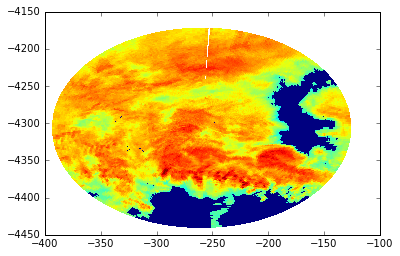

In [60]:
pl.pcolormesh(all_lon[1,:,:], all_lat[1,:,:],all_scans[1,:,:])

In [12]:
import datetime

In [13]:
gr_data.keys()

['elang',
 'sdate',
 'r0',
 'source',
 'nbeam',
 'lon',
 'ntilt',
 'a0',
 'ngate',
 'refl',
 'date',
 'lat',
 'alt',
 'dr']

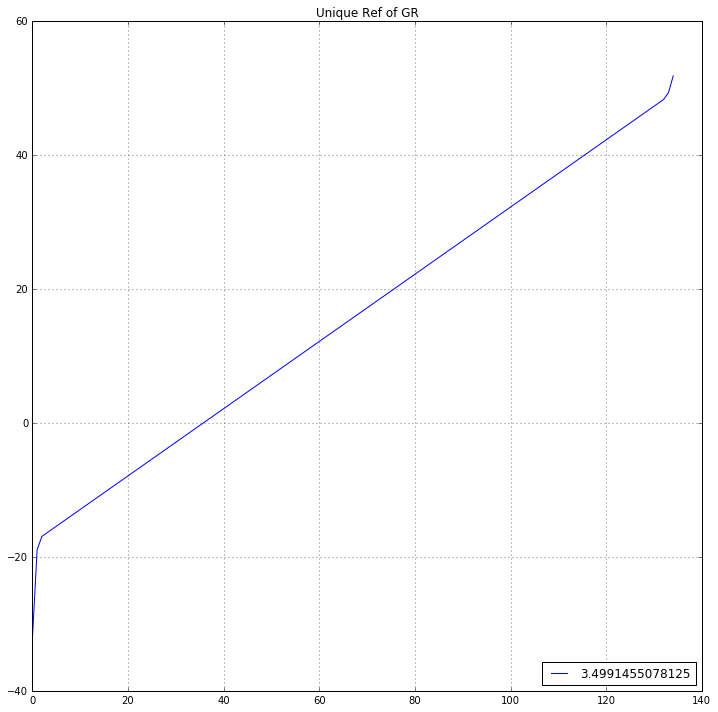

In [14]:
pl.figure(figsize=(12,12))
for ii in range(len(gr_data['refl'])):
    pl.plot(np.unique(gr_data['refl'][ii]), label=gr_data['elang'][ii])
pl.title('Unique Ref of GR')
pl.grid()
pl.legend(loc='lower right')

In [15]:
######### GR data and att
ee = 0
# number of rays in gr sweep
nray_gr = gr_data['nbeam'].astype("i4")[ee]
# number of gates in gr beam
ngate_gr = gr_data['ngate'].astype("i4")[ee]
# number of sweeps
nelev = gr_data['ntilt']
# elevation of sweep (degree)
elev_gr = gr_data['elang'][ee]
# gate length (meters)
dr_gr = gr_data['dr'][ee]
# reflectivity array of sweep
ref_gr = gr_data['refl'][ee]
# sweep datetime stamp
#date_gr = gr_data['sdate'][ee]
# range of first gate
r0_gr = gr_data['r0'][ee]
# azimuth angle of first beam
a0_gr = gr_data['a0'][ee]
# Longitude of GR
lon0_gr = gr_data['lon']
# Latitude of GR
lat0_gr = gr_data['lat']
# Altitude of GR (meters)
alt0_gr = gr_data['alt']
# Beam width of GR (degree)
bw_gr = 1.
print(ref_gr.shape, )

((360, 180),)


In [16]:
coord = wrl.georef.sweep_centroids(nray_gr, dr_gr, ngate_gr, elev_gr)
coords = wrl.georef.spherical_to_proj(coord[..., 0],
                                      np.degrees(coord[..., 1]),
                                      coord[..., 2],
                                      (lon0_gr, lat0_gr, alt0_gr))
lon = coords[..., 0]
lat = coords[..., 1]
alt = coords[..., 2]
bbox = wrl.zonalstats.get_bbox(lon, lat)
print("Radar bounding box:\n\t%.2f\n%.2f           %.2f\n\t%.2f" %
      (bbox['top'], bbox['left'], bbox['right'], bbox['bottom']))

Radar bounding box:
	53.01
4.40           9.54
	49.80


In [17]:
# read spaceborn SR data
#if platf == "gpm":
#    sr_data = wrl.io.read_gpm(gpm_file, bbox)
#elif platf == "trmm":
#    sr_data = wrl.io.read_trmm(trmm_2a23_file, trmm_2a25_file, bbox)
#else:
#    raise("Invalid platform")
sr_data = wrl.io.read_gpm(gpm_file, bbox)


In [18]:
gr_data

{'a0': array([0.04394531]),
 'alt': 185.0,
 'date': '2014729224623',
 'dr': array([1000.]),
 'elang': array([3.49914551]),
 'lat': 51.405556,
 'lon': 6.966944,
 'nbeam': array([360.]),
 'ngate': array([180], dtype=int16),
 'ntilt': 1,
 'r0': array([0.]),
 'refl': array([[[-32.5019685 ,  -5.89763784,  -4.89370084, ..., -32.5019685 ,
          -32.5019685 , -32.5019685 ],
         [-32.5019685 ,   2.1338582 ,  -4.89370084, ..., -32.5019685 ,
          -32.5019685 , -32.5019685 ],
         [-32.5019685 ,   0.62795269,  -4.39173234, ..., -32.5019685 ,
          -32.5019685 , -32.5019685 ],
         ...,
         [-32.5019685 ,   7.65551174,  -8.40748036, ..., -32.5019685 ,
          -32.5019685 , -32.5019685 ],
         [-32.5019685 ,  -8.40748036,  -9.41141737, ..., -32.5019685 ,
          -32.5019685 , -32.5019685 ],
         [-32.5019685 ,  -7.40354335,  -7.90551186, ..., -32.5019685 ,
          -32.5019685 , -32.5019685 ]]]),
 'sdate': array(['2014729224623'], dtype='|S13'),
 'source':

(102, 49, 176)


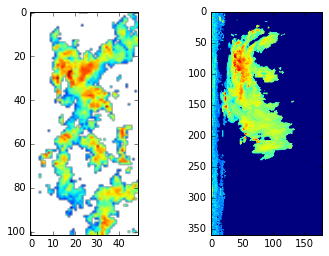

In [19]:
pl.subplot(1,2,1)
refl = sr_data['refl']
print refl.shape
pl.imshow(refl[:,:,12])

pl.subplot(1,2,2)
#print (gr_data['refl'][0,:,:].shape)
pl.imshow(gr_data['refl'][0])


In [20]:
# Longitudes of SR scans
sr_lon = sr_data['lon']
# Latitudes of SR scans
sr_lat = sr_data['lat']
# Precip flag
pflag = sr_data['pflag']
# Number of scans on SR data
nscan_sr= sr_data['nscan']
# Number of rays in one SR scan
nray_sr = sr_data['nray']
# Number of gates in one SR ray
ngate_sr = sr_data['nbin']

In [21]:

print (sr_lon.shape, sr_lat.shape, pflag.shape, )
print (nscan_sr, nray_sr, ngate_sr)
print (sr_data.keys())
#print (sr_data['refl'])

((102, 49), (102, 49), (102, 49))
(102, 49, 176)
['nscan', 'pflag', 'zbb', 'zenith', 'nray', 'lon', 'ptype', 'lat', 'refl', 'date', 'nbin', 'quality', 'sfc', 'bbwidth']


In [22]:
# Calculate equivalent earth radius
wgs84 = wrl.georef.get_default_projection()
re1 = wrl.georef.get_earth_radius(lat0_gr, wgs84)
print("Earth radius 1:", re1)
a = wgs84.GetSemiMajor()
b = wgs84.GetSemiMinor()
print("SemiMajor, SemiMinor:", a, b)

# Set up aeqd-projection gr-centered
rad = wrl.georef.proj4_to_osr(('+proj=aeqd +lon_0={lon:f} ' +
                                   '+lat_0={lat:f} +a={a:f} ' +
                                   '+b={b:f}').format(lon=lon0_gr,
                                                      lat=lat0_gr,
                                                      a=a, b=b))
re2 = wrl.georef.get_earth_radius(lat0_gr, rad)
print("Earth radius 2:", re2)


('Earth radius 1:', 6365116.483644162)
('SemiMajor, SemiMinor:', 6378137.0, 6356752.314245179)
('Earth radius 2:', 6365116.483644053)


In [24]:
# create gr range and azimuth arrays
rmax_gr = r0_gr + ngate_gr * dr_gr
r_gr = np.arange(0, ngate_gr) * dr_gr + dr_gr/2.
az_gr = np.arange(0, nray_gr) - a0_gr
print("Range/Azi-Shape:", r_gr.shape, az_gr.shape)

# create gr polar grid and calculate aeqd-xyz coordinates
gr_polargrid = np.meshgrid(r_gr, az_gr)
gr_xyz, rad = wrl.georef.spherical_to_xyz(gr_polargrid[0], gr_polargrid[1], elev_gr, (lon0_gr, lat0_gr, alt0_gr ))
print("XYZ-Grid-Shape:", gr_xyz.shape)

# create gr poygon array in aeqd-xyz-coordinates
gr_poly, rad1 = wrl.georef.spherical_to_polyvert(r_gr, az_gr, elev_gr, (lon0_gr, lat0_gr, alt0_gr))
print(gr_poly.shape, 360 * 600)
gr_poly.shape = (nray_gr, ngate_gr, 5, 3)

# get radar domain (outer ring)
gr_domain = gr_xyz[:,-1,0:2]
gr_domain = np.vstack((gr_domain, gr_domain[0]))
print("Domain-Shape:", gr_domain.shape)

('Range/Azi-Shape:', (180,), (360,))
('XYZ-Grid-Shape:', (360, 180, 3))
((64800, 5, 3), 216000)
('Domain-Shape:', (361, 2))


In [25]:
sr_x, sr_y = wrl.georef.reproject(sr_lon, sr_lat,
                                      projection_source=wgs84,
                                      projection_target=rad)
sr_xy = np.dstack((sr_x, sr_y))
print("SR-GRID-Shapes:", sr_x.shape, sr_y.shape, sr_xy.shape)

('SR-GRID-Shapes:', (102, 49), (102, 49), (102, 49, 2))


[ 0  2 10 11]


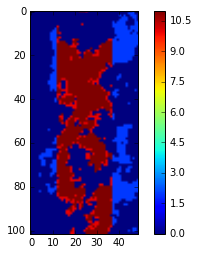

In [26]:
pl.imshow(pflag)
pl.colorbar()
print (np.unique(pflag))
#pl.plot(pflag)

(102, 49, 2)
(102, 49)
((102, 49), (102, 49, 2))
((102, 49), (4998, 2))
[False  True]


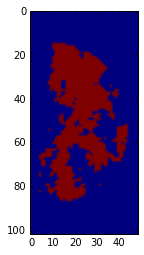

In [27]:
# Create ZonalData for spatial subsetting (inside GR range domain)

# get precip indexes
print(sr_xy.shape)
print(pflag.shape)

####################!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#########!!!!!!!!!!!!!!!!!!!! eigentlich == 2 ===?????

precip_mask = (pflag >= 2) & wrl.zonalstats.get_clip_mask(sr_xy, gr_domain, rad)

# get iscan/iray boolean arrays
print(precip_mask.shape, sr_xy.shape)
print(pflag.shape, sr_xy.reshape(-1, sr_xy.shape[-1]).shape)
pl.imshow(precip_mask)

#pl.colorbar()
print (np.unique(precip_mask))

# Parallax Correction
---------------------------

In [28]:
print("NRAY", nray_sr)
print("NBIN", ngate_sr)

# use localZenith Angle
alpha = sr_data['zenith']
beta = abs(-17.04 + np.arange(nray_sr) * bw_sr)

# Correct for parallax, get 3D-XYZ-Array
#   xyzp_sr: Parallax corrected xyz coordinates
#   r_sr_inv: range array from ground to SR platform
#   zp: SR bin altitudes
xyp_sr, r_sr_inv, z_sr = wrl.georef.correct_parallax(sr_xy, ngate_sr, dr_sr, alpha)
print(xyp_sr.shape, r_sr_inv.shape, z_sr.shape)
xyzp_sr = np.concatenate((xyp_sr, z_sr[..., np.newaxis]),
                   axis=-1)
print(sr_xy.shape)
print("SR_XYP:", xyp_sr.shape, xyzp_sr.shape, r_sr_inv.shape, z_sr.shape)

('NRAY', 49)
('NBIN', 176)
((102, 49, 176, 2), (176,), (102, 49, 176))
(102, 49, 2)
('SR_XYP:', (102, 49, 176, 2), (102, 49, 176, 3), (176,), (102, 49, 176))


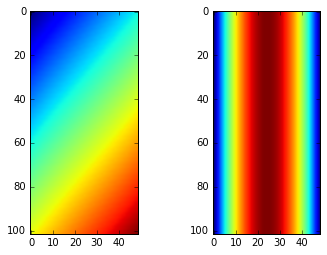

In [29]:
pl.subplot(1,2,1)
pl.imshow(xyp_sr[:,:,160,0])
pl.subplot(1,2,2)
pl.imshow(xyzp_sr[:,:,160,2])


# Compute spherical coordinates of SR bins with regard to GR
-------------------------------

(102, 49, 176)

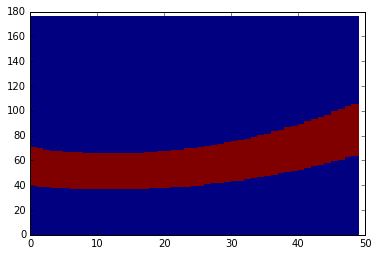

In [30]:
r_sr, az_sr, elev_sr = wrl.georef.xyz_to_spherical(xyzp_sr, alt0_gr, proj=rad)
#TODO: hardcoded 1.0
mask = (elev_sr > (1.0 - bw_gr/2.)) & (elev_sr < (1.0 + bw_gr/2.))
pl.figure()
pl.pcolormesh((mask[9,:,:].T))
mask.shape

# Compute SR and GR pulse volumes
------------------------------------

## Calculate distance from orbit $r_s$

In [31]:
rs = wrl.georef.dist_from_orbit(zt, alpha, beta, r_sr_inv, re1)

# SR pulse volume
--------------------------------

In [32]:

# Small anngle approximation
vol_sr2  = np.pi * dr_sr * rs**2 * np.radians(bw_sr / 2.)**2

# Or using wradlib's native function
vol_sr = wrl.qual.pulse_volume(rs, dr_sr, bw_sr)

# Evaluate difference between both approaches
print("Min. difference (m3):", (vol_sr - vol_sr2).min())
print("Max. difference (m3): ", (vol_sr - vol_sr2).max())
print("Average rel. difference (%):", round(np.mean(vol_sr-vol_sr2)*100./np.mean(np.mean(vol_sr2)), 4))

# Verdict: differences are negligble - use wradlibs's native function!



('Min. difference (m3):', 57223.37443113327)
('Max. difference (m3): ', 70340.18861055374)
('Average rel. difference (%):', 0.0026)


# GR Pulse Volume
----------------------------------

In [33]:


# GR pulse volumes
#   along one beam
vol_gr = wrl.qual.pulse_volume(r_gr, dr_gr, bw_gr)
#   with shape (nray_gr, ngate_gr)
vol_gr = np.repeat(vol_gr, nray_gr).reshape((nray_gr, ngate_gr), order="F")

print (vol_gr.shape)

(360, 180)


# Calculate horizontal and vertical dimensions $R_S$ and $D_S$ of SR bin
---------------------------------

In [34]:

Rs = 0.5 * (1 +  np.cos(np.radians(alpha)))[:,:,np.newaxis] * rs * np.tan(np.radians(bw_sr/2.))
Ds = dr_sr / np.cos(np.radians(alpha))
Ds = np.broadcast_to(Ds[..., np.newaxis], Rs.shape)

print (Rs.shape, Ds.shape)

((102, 49, 176), (102, 49, 176))


# Median Brightband Width/Height
----------------------------

In [35]:

print(z_sr.shape)
print(sr_data['zbb'].shape, sr_data['bbwidth'].shape, sr_data['quality'].shape)
ratio, ibb = wrl.qual.get_bb_ratio(sr_data['zbb'], sr_data['bbwidth'], sr_data['quality'], z_sr)
print(ratio.shape)
zbb = sr_data['zbb'].copy()
zbb[~ibb] = np.nan
print(np.nanmin(ratio[..., 9]), np.nanmax(ratio[..., 9]))



(102, 49, 176)
((102, 49), (102, 49), (102, 49))
(102, 49, 176)
(-2.9241710223881556, -2.84018343473411)


# Convert SR Ku in S-Band Ref and vice versa
----------------------------------

In [36]:
ref_sr = sr_data['refl'].filled(np.nan)
print(ref_sr.shape, ratio.shape)

'''
Hier ein eigenes Convert zwischen KU und X BAND
'''

((102, 49, 176), (102, 49, 176))


'\nHier ein eigenes Convert zwischen KU und X BAND\n'

# Matching SR / GR
------------------

In [37]:
# First assumption: no valid SR bins (all False)
valid = np.asarray(elev_sr, dtype=np.bool)==False
print(valid.shape, precip_mask.shape)

# SR is inside GR range and is precipitating
iscan = precip_mask.nonzero()[0]
iray = precip_mask.nonzero()[1]
valid[iscan,iray] = True

# SR bins intersect with GR sweep
valid = valid & (elev_sr >= (elev_gr-bw_gr/2.)) & (elev_sr <= (elev_gr+bw_gr/2.))

# Number of matching SR bins per profile
nvalids = np.sum(valid, axis=2)

# scan and ray indices for profiles with at least one valid bin
vscan, vray = np.where(nvalids>0)

# number of profiles with at least one valid bin
nprof = len(vscan)
print(vscan.shape)
print(valid.shape)

((102, 49, 176), (102, 49))
(1292,)
(102, 49, 176)


(102, 49, 176, 3)
((1292, 3), (102, 49))


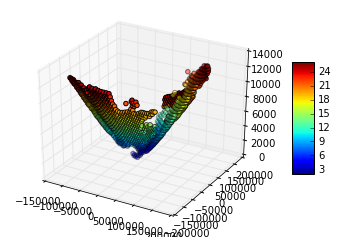

In [38]:
# average coordinates
xyz_v1 = xyzp_sr.copy()
print(xyz_v1.shape)
xyz_v1[~valid] = np.nan
xyz_c1 = xyzp_sr.copy()
xyz_c1[~valid] = 0
c = np.count_nonzero(xyz_c1[..., 0], axis=2)
ntotsr = c[vscan, vray]
xyz_m1 = np.nanmean(xyz_v1,axis=2)
xyz = xyz_m1[vscan, vray]
print(xyz.shape, c.shape)

# approximate Rs
rs_v1 = Rs.copy()
rs_v1[~valid] = np.nan
rs_m1 = np.nanmax(rs_v1, axis=2)
rs_prof = rs_m1[vscan, vray]
ds = rs_prof

# approximate Ds
ds_v1 = Ds.copy()
ds_v1[~valid] = np.nan
ds_m1 = np.nansum(ds_v1, axis=2)
ds_prof = ds_m1[vscan, vray]
dz = ds_prof

# approximate Vs
vs_v1 = vol_sr.copy()
vs_v1[~valid] = np.nan
vs_m1 = np.nansum(vs_v1, axis=2)
vs_prof = vs_m1[vscan, vray]
volsr1 = vs_prof

from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure()
ax = fig.add_subplot(111, projection='3d')
pppl = ax.scatter(xyz_m1[..., 0], xyz_m1[..., 1], xyz_m1[..., 2], c=c.ravel())
fig.colorbar(pppl, shrink=0.5, aspect=5)


# Calculate spherical coordinates of SR sample volume with respect to GR
--------------------------------------------

In [39]:
r_sr, az_sr, el_rs = wrl.georef.xyz_to_spherical(xyz, alt0_gr, proj=rad)

# Average SR reflectivity
------------------------------------------

In [40]:


ref_sr_1 = wrl.trafo.idecibel(ref_sr)
ref_sr_1[~valid] = np.nan
refsr1a = np.nanmean(ref_sr_1, axis=2)[vscan,vray]
refsr1a = wrl.trafo.decibel(refsr1a)

#ref_sr_2 = wrl.trafo.idecibel(ref_sr_ss)
#ref_sr_2[~valid] = np.nan
#refsr2a = np.nanmean(ref_sr_2, axis=2)[vscan,vray]
#refsr2a = wrl.trafo.decibel(refsr2a)

#ref_sr_3 = wrl.trafo.idecibel(ref_sr_sh)
#ref_sr_3[~valid] = np.nan
#refsr3a = np.nanmean(ref_sr_3, axis=2)[vscan,vray]
#refsr3a = wrl.trafo.decibel(refsr3a)


print(refsr1a.shape)



(1292,)


# Identify which GR bins actually intersect with the SR footprint
---------------------
## Create Zonal Data Source of matching SR profile

In [41]:
zds = wrl.zonalstats.DataSource(xyz[:, 0:2].reshape(-1, 2), rad)
print(zds.ds.GetLayer().GetFeatureCount())

1292


# Create SR beam polygons using R
--------------------------

In [42]:
tmp_trg_lyr = zds.ds.GetLayer()
trg_poly = []
for i, feat in enumerate(tmp_trg_lyr):
    geom = feat.GetGeometryRef().Buffer(rs_prof[i])
    poly = wrl.georef.ogr_to_numpy(geom)
    trg_poly.append(poly)

# Create ZonalDataPoly for GR and SR profiles
------------------------

In [43]:
%%time
print("creating")
zdp = wrl.zonalstats.ZonalDataPoly(gr_poly[..., 0:2].reshape(-1, 5, 2), trg_poly, srs=rad)
zdp.dump_vector('m3d_zonal_poly_{0}'.format(platf))

creating
CPU times: user 28.7 s, sys: 167 ms, total: 28.9 s
Wall time: 29.1 s


In [44]:
%%time
print("loading")
obj3 = wrl.zonalstats.GridCellsToPoly('m3d_zonal_poly_{0}'.format(platf))

loading
CPU times: user 45.1 s, sys: 176 ms, total: 45.3 s
Wall time: 45.2 s


# Average GR volume and reflectivity
---------------------------

In [45]:
%%time
print(obj3.ix.shape)
volgr1 = np.array([np.sum(vol_gr.ravel()[obj3.ix[i]])
                   for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
print(volgr1.shape)

ref_gr_i = wrl.trafo.idecibel(ref_gr.ravel())
#ref_gr_ku_i = wrl.trafo.idecibel(ref_gr_ku.ravel())
refgr1a = np.array([np.nanmean(ref_gr_i[obj3.ix[i]])
             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
refgr1a = wrl.trafo.decibel(refgr1a)
#refgr2a = np.array([np.nanmean(ref_gr_ku_i[obj3.ix[i]])
#             for i in np.arange(len(obj3.ix))[~obj3.check_empty()]])
#refgr2a = wrl.trafo.decibel(refgr2a)

(1292,)
(1292,)
CPU times: user 261 ms, sys: 12.2 ms, total: 274 ms
Wall time: 265 ms


In [46]:
##### betrachten von noederschlags relevanten Reflek und Threshold DPR Ku = 15 DBZ
from satlib import corcor

# Threshold festlegen
---------------------------------

In [47]:
TH = 15
refsr1a[refsr1a<=TH]=np.nan
refgr1a[refgr1a<=TH]=np.nan
ref_gr[ref_gr<=TH]=np.nan
ref_sr[ref_sr<=TH]=np.nan

# PLOT
______________

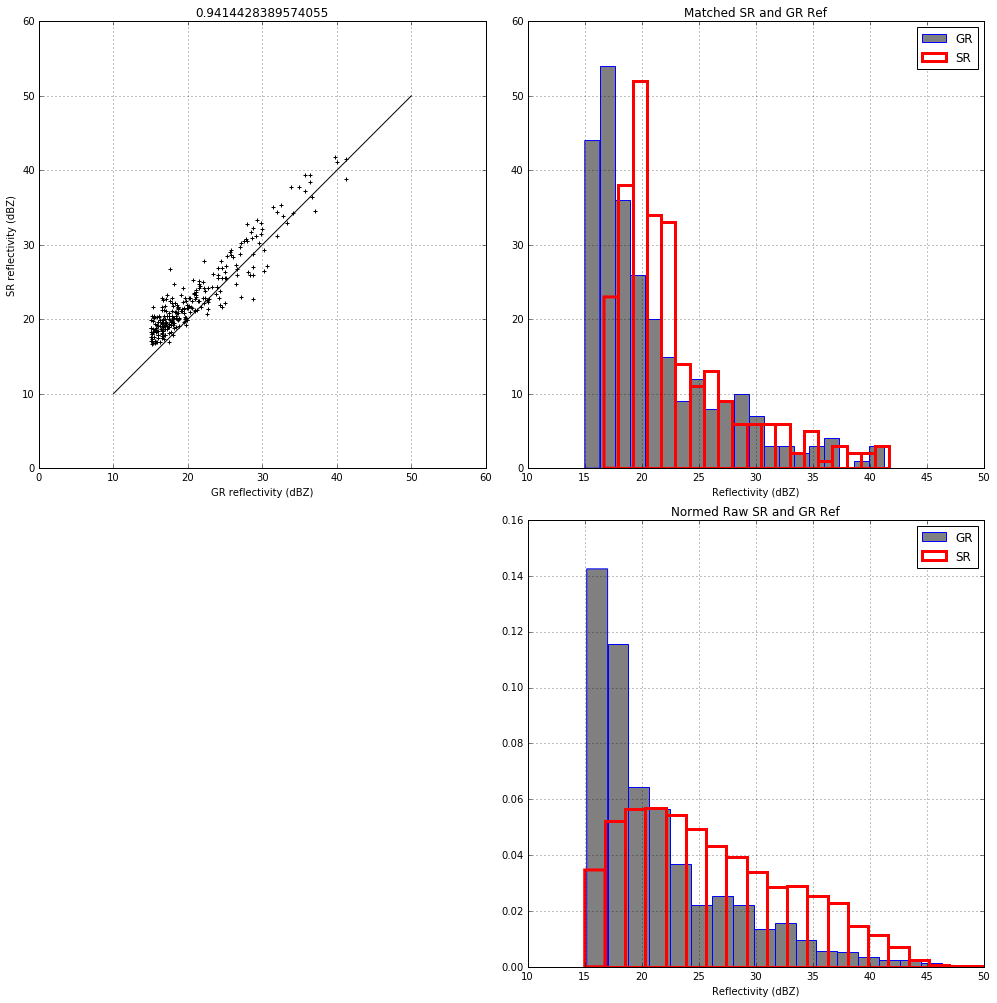

In [48]:
fig = pl.figure(figsize=(14,14))
ax = fig.add_subplot(221, aspect="equal")
pl.scatter(refgr1a, refsr1a, marker="+", c="black")
pl.plot([10,50],[10,50], linestyle="solid", color="black")
#pl.xlim(10,50)
#pl.ylim(10,50)
pl.grid()
pl.xlabel("GR reflectivity (dBZ)")
pl.ylabel("SR reflectivity (dBZ)")
pl.title(corcor(refgr1a, refsr1a))

ax = fig.add_subplot(222)
m1 = ~np.isnan(refgr1a)& ~np.isnan(refsr1a)

pl.hist(refgr1a[m1], bins=20, edgecolor="blue", facecolor="grey", label="GR")
pl.hist(refsr1a[m1], bins=20, edgecolor="red", facecolor="None", label="SR", lw=3)
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.title('Matched SR and GR Ref')
pl.xlim(10,50)

ax = fig.add_subplot(224)
r_gr = ref_gr.reshape(ref_gr.shape[0]*ref_gr.shape[1])
r_sr = ref_sr.reshape(ref_sr.shape[0]*ref_sr.shape[1]*ref_sr.shape[2])
m1, m2 = ~np.isnan(r_gr), ~np.isnan(r_sr)

pl.hist(r_gr[m1], bins=20, edgecolor="blue", facecolor="grey", label="GR", normed=1)
pl.hist(r_sr[m2], bins=20, edgecolor="red", facecolor="None", label="SR", lw=3, normed=1)
pl.xlabel("Reflectivity (dBZ)")
pl.legend()
pl.grid()
pl.title('Normed Raw SR and GR Ref')
pl.xlim(10,50)
#fig.suptitle("uncorrected GR vs uncorrected SR")

pl.tight_layout()


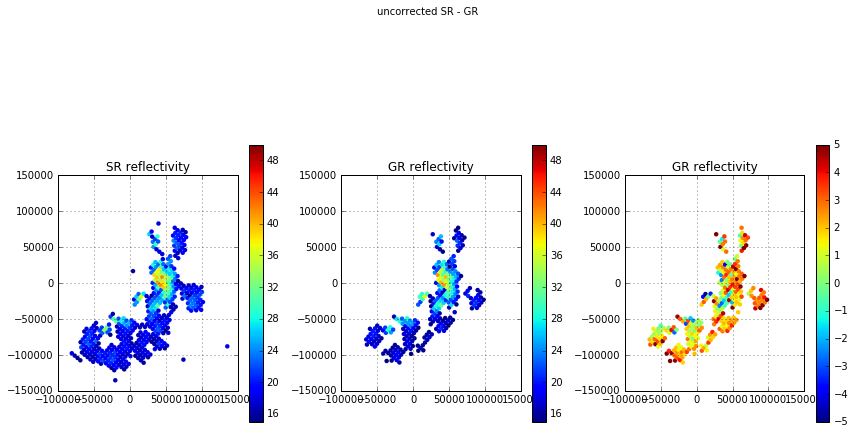

In [49]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refsr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(-100000, 150000)
pl.ylim(-150000, 150000)
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refgr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(-100000, 150000)
pl.ylim(-150000, 150000)
pl.grid()
pl.colorbar(shrink=0.5)
fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="equal")
pl.scatter(xyz[..., 0], xyz[...,1], c=refsr1a-refgr1a,vmin=-5,vmax=5 ,edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(-100000, 150000)
pl.ylim(-150000, 150000)
pl.grid()
pl.colorbar(shrink=0.5)
fig.suptitle("uncorrected SR - GR")
pl.tight_layout()

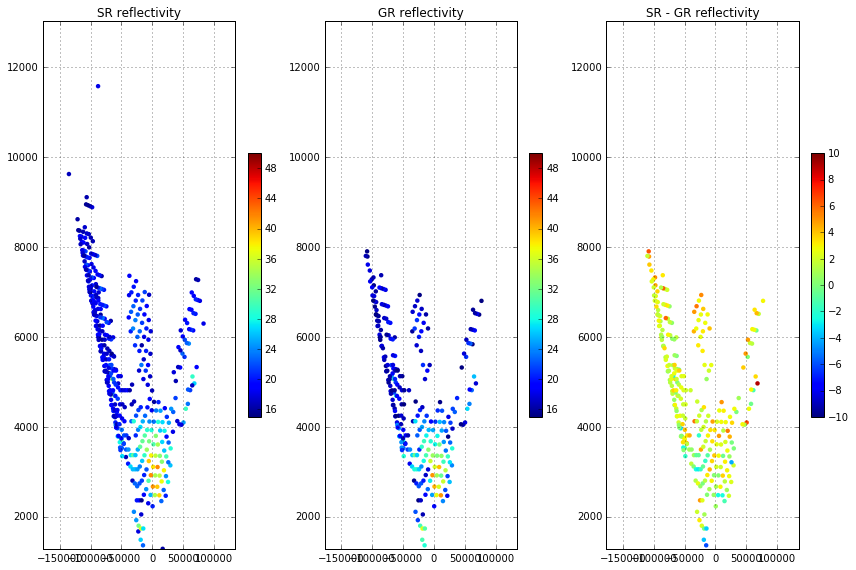

In [50]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(131, aspect="auto")
pl.scatter(xyz[..., 1], xyz[...,2], c=refsr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("SR reflectivity")
pl.xlim(np.nanmin(xyz[...,1]),np.nanmax(xyz[...,1]))
pl.ylim(np.nanmin(xyz[...,2]),np.nanmax(xyz[...,2]))
pl.grid()
pl.colorbar(shrink=0.5)

ax = fig.add_subplot(132, aspect="auto")
pl.scatter(xyz[..., 1], xyz[...,2], c=refgr1a, cmap=pl.cm.jet, vmin=TH, vmax=50, edgecolor="None")
pl.title("GR reflectivity")
pl.xlim(np.nanmin(xyz[...,1]),np.nanmax(xyz[...,1]))
pl.ylim(np.nanmin(xyz[...,2]),np.nanmax(xyz[...,2]))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected GR vs uncorrected SR")
pl.tight_layout()

ax = fig.add_subplot(133, aspect="auto")
pl.scatter(xyz[..., 1], xyz[...,2], c=refsr1a-refgr1a, cmap='jet',vmin=-10,vmax=10 ,edgecolor="None")
pl.title("SR - GR reflectivity")
pl.xlim(np.nanmin(xyz[...,1]),np.nanmax(xyz[...,1]))
pl.ylim(np.nanmin(xyz[...,2]),np.nanmax(xyz[...,2]))
pl.grid()
pl.colorbar(shrink=0.5)
#fig.suptitle("uncorrected SR - GR")
pl.tight_layout()

# ????? Wie groß ist der Fehler in unseren Breiten zwischen 3d Korrigier und nicht korrigiert ???

('Corellation: ', '0.9414428389574055')


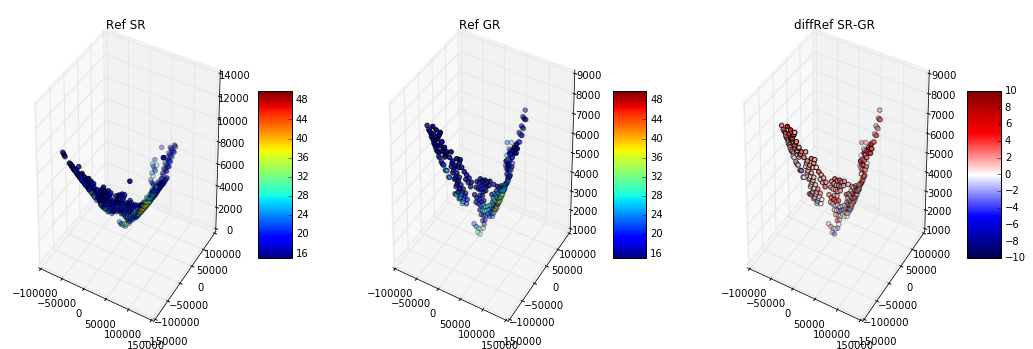

In [51]:
from mpl_toolkits.mplot3d import Axes3D
fig = pl.figure(figsize=(18,6))
ax1 = fig.add_subplot(131, projection='3d')
pppl = ax1.scatter(xyz[..., 0], xyz[..., 1], xyz[..., 2], c=refsr1a.ravel(), vmin=TH, vmax=50)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax1.set_title('Ref SR')

ax2 = fig.add_subplot(132, projection='3d')
pppl = ax2.scatter(xyz[..., 0], xyz[..., 1], xyz[..., 2], c=refgr1a.ravel(), vmin=TH, vmax=50)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax2.set_title('Ref GR')

ax3 = fig.add_subplot(133, projection='3d')
pppl = ax3.scatter(xyz[..., 0], xyz[..., 1], xyz[..., 2], c=refsr1a.ravel()-refgr1a.ravel(),
                   cmap='seismic',vmin=-10,vmax=10)
fig.colorbar(pppl, shrink=0.5, aspect=5)
ax3.set_title('diffRef SR-GR')

from satlib import corcor
print ('Corellation: ',corcor( refgr1a, refsr1a))

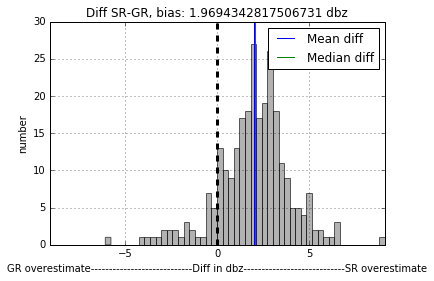

In [52]:
ax = fig.add_subplot(111)
GRi, SRi = refgr1a, refsr1a
mmi = ~np.isnan(GRi)& ~np.isnan(SRi)

pl.hist(SRi[mmi]-GRi[mmi],bins=50, facecolor="grey", alpha=0.6)
pl.axvline(np.mean(SRi[mmi]-GRi[mmi]), color='blue', label='Mean diff')
pl.axvline(np.median(SRi[mmi]-GRi[mmi]), color='green', label='Median diff')
pl.axvline(0, color='black',ls='--',lw=3)

xmin, xmax = np.nanmin(SRi[mmi]-GRi[mmi]), np.nanmax(SRi[mmi]-GRi[mmi])
limits = np.nanmax([abs(xmin),abs(xmax)])
pl.xlim(-limits,limits)

pl.title('Diff SR-GR, bias: '+str( np.sum(SRi[mmi]-GRi[mmi])/len(SRi[mmi]-GRi[mmi]))+' dbz')
pl.grid()
pl.legend()
pl.xlabel('GR overestimate----------------------------Diff in dbz----------------------------SR overestimate')
pl.ylabel('number')

In [53]:
refgr1a.shape

(1292,)

In [54]:
xyz.shape

(1292, 3)

In [55]:
2.8*40

112.0